In [36]:
from scipy import stats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from itertools import combinations

## Урок 7. Линейная регрессия. Однофакторный дисперсионный анализ.

**1. Даны значения величины заработной платы заемщиков банка (salary) и значения их поведенческого кредитного скоринга (scoring):**

```
salary = [35, 45, 190, 200, 40, 70, 54, 150, 120, 110]
scoring = [401, 574, 874, 919, 459, 739, 653, 902, 746, 832]
```

**Возьмём в качестве признака значение salary, а в качестве целевой переменной - scoring.**

**1.1 Найдите коэффициенты линейной регрессии с помощью формул для парной регрессии, а затем с помощью метода наименьших квадратов.**

**1.2 Постройте scatter plot по данным и отметьте на нём прямую линейной регрессии, полученную в п. 1.**

**1.3 Посчитайте коэффициент детерминации, среднюю ошибку аппроксимации.**

**1.4 Оцените построенное уравнение регрессии с помощью F-критерия Фишера.**

**1.5 Постройте для коэффициентов регрессии доверительные интервалы с помощью t-статистики Стьюдента.**


In [37]:
salary = np.array([35, 45, 190, 200, 40, 70, 54, 150, 120, 110])
scoring = np.array([401, 574, 874, 919, 459, 739, 653, 902, 746, 832])

1.1 Модель по формулам парной регрессии и методу наименьших квадратов.

При рассчете по коэффициентам парной регрессии $b_1 = \frac{\sigma_{XY}}{\sigma^2_X}$, $b_0 = \overline{Y} - b_1 \cdot \overline{X}$.

In [38]:
cov_matrix = np.cov(salary, scoring, ddof=1)
b1 = cov_matrix[0,1]/cov_matrix[0,0]
b0 = scoring.mean() - b1*salary.mean()

b0, b1

(444.1773573243596, 2.620538882402765)

Модель линейной регрессии имеет вид $y = 444.18 + 2.62 \cdot x$.

При рассчете по методу наименьших квадратов $b = (X^TX)^{-1}X^Ty$. Здесь $b$ - вектор коэффициентов при признаках, $b = (b_0, b_1)$. Дополним матрицу признаков `salary` единичным столбцом, получим матрицу $X$.

In [39]:
X = np.hstack((
    np.ones((salary.size, 1)),
    salary.reshape(-1, 1)
))
X

array([[  1.,  35.],
       [  1.,  45.],
       [  1., 190.],
       [  1., 200.],
       [  1.,  40.],
       [  1.,  70.],
       [  1.,  54.],
       [  1., 150.],
       [  1., 120.],
       [  1., 110.]])

 Посчитаем определитель матрицы $X^TX$.

In [40]:
np.linalg.det(X.T.dot(X))

349464.00000000023

Определитель матрицы $X^TX$ не близок к нулю, следовательно можно использовать аналитические формулы метода наименьших квадратов.

In [41]:
b = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(scoring)
b

array([444.17735732,   2.62053888])

Получили такой же результат, как и при расчете по формулам парной регрессии. Уравнение модели: $y = 444.18 + 2.62 \cdot x$.

In [42]:
scoring_predict = X.dot(b)
scoring_predict

array([535.89621821, 562.10160703, 942.07974498, 968.2851338 ,
       548.99891262, 627.61507909, 585.68645697, 837.25818968,
       758.64202321, 732.43663439])

In [43]:
np.hstack((
    scoring_predict.reshape(-1, 1),
    scoring.reshape(-1, 1)
))

array([[535.89621821, 401.        ],
       [562.10160703, 574.        ],
       [942.07974498, 874.        ],
       [968.2851338 , 919.        ],
       [548.99891262, 459.        ],
       [627.61507909, 739.        ],
       [585.68645697, 653.        ],
       [837.25818968, 902.        ],
       [758.64202321, 746.        ],
       [732.43663439, 832.        ]])

1.2 Графическое представление выборки и модели линейной регрессии.

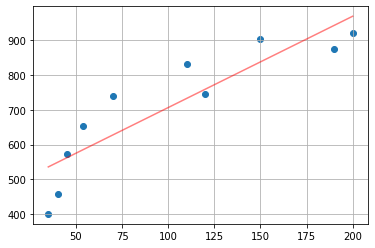

In [44]:
x = np.linspace(salary.min(), salary.max(), 100)

plt.scatter(salary, scoring)
plt.plot(x, b0 + x*b1, color='red', alpha=0.5)
plt.grid()
plt.show()

1.3 Коэффициент детерминации и средня ошибка аппроксимации.

Кожффициент детерминации 

$$R^2 = 1 - \frac{\sigma^2_{res}}{\sigma^2_y}$$

In [45]:
D_res = (scoring_predict - scoring).var(ddof=1)
D_y = scoring.var(ddof=1)
R2 = 1 - D_res/D_y
R2

0.7876386635293685

In [46]:
# проверка по коэффицентам корреляции Пирсона
np.corrcoef(salary, scoring)[0, 1] ** 2

0.7876386635293682

78% зависимости объясняется построенной моделью.

Ошибка аппроксимации

$$\overline{A} = \frac{1}{n} \sum_{i=1}^{n} \Bigl| \frac{y_i - z_i}{y_i} \Bigr|$$

In [12]:
A = np.abs(1 - scoring_predict/scoring).sum() / len(scoring)
A

0.11469251843561712

Ошибка апроксимации достаточно низкая, так что мождно сказать что построенная модель точная.

1.4 Оценка уравнения модели с помощью F-критерия Фишера.

$$F = \dfrac{R^2 / k}{(1 - R^2) / (n - k - 1)} = \dfrac{R^2 / k_1}{(1 - R^2) / k_2}$$

Для нашей модели число факторов $k=1$, число наблюдений $n=10$. Значит $k_1=k=1$, $k_2=n-k-1=8$. Для уровня значимости $\alpha = 0.05$ посчитаем значение $F_{crit} = F(1, 8)$.

In [13]:
k1 = 1
k2 = 8
alpha = 0.05

F = (R2/k1) / ((1-R2)/k2)
F_crit = stats.f.ppf(1 - alpha, k1, k2)

F, F_crit

(29.67164085966449, 5.317655071578714)

Значение статистики попадает в критическую область, значит гипотеза $H_0$ о том что фактические коэффициенты при факторах у модели равны нулю, отвергается. Построенная модель статистически значимая.

1.5 Доверительные интервалы для коэффициентов регрессии по t-статистике Стьюдента.

Стандартная ошибка кожэффициента наклона:

$$S_{slope} = \sqrt{\dfrac{\frac{1}{n - 2} \displaystyle\sum_{i=1}^{n}(y_i - z_i)^2}{\displaystyle\sum_{i=1}^n (x_i - \overline{x})^2}},$$



Статистика $T = \dfrac{\hat{b}_1 - b_1}{S_{slope}}$ имеет распределение Стьюдента. Здесь $\hat{b}_1$ это полученное значение коэффициента наклона. Для уровня доверия $p = 1 - \alpha$ доверительный интервал:

$$P \left( \hat{b}_1 - t_{1 - \alpha/2, \: n - 2} \cdot S_{slope} \leq b_1 \leq \hat{b}_1 + t_{1 - \alpha/2, \: n - 2} \cdot S_{slope} \right) = p$$


In [14]:
# стандартная ошибка коэффициента наклона
def standard_error_slope(
        x: np.ndarray,
        y: np.ndarray,
        z: np.ndarray,
) -> float:
    n = len(x)
    upper = ((y - z) ** 2).sum() / (n - 2)
    lower = ((x - x.mean()) ** 2).sum()
    
    return np.sqrt(upper / lower)

In [15]:
s_slope = standard_error_slope(salary, scoring, scoring_predict)
s_slope

0.48108279568516016

In [16]:
alpha = 0.05

t = stats.t.ppf(1 - alpha / 2, df=8)
t

2.3060041350333704

In [17]:
L = b1 - t * s_slope
U = b1 + t * s_slope

L, U

(1.5111599662593715, 3.7299177985461585)

Получили доверительный интервал для коэффициента наклона $P \left(1.51 \leq b_1 \leq 3.73 \right) = 0.95$.

Стандартная ошибка коэффициента сдвига:

$$S_{intercept} = S_{slope} \cdot \sqrt{\dfrac{1}{n} \displaystyle\sum_{i=1}^n x_i^2}.$$

In [18]:
# стандартная ошибка коэффициента сдвига
def standard_error_intercept(
        x: np.ndarray,
        y: np.ndarray,
        z: np.ndarray,
) -> float:
    
    return standard_error_slope(x, y, z) * np.sqrt((x ** 2).mean())

In [19]:
s_intercept = standard_error_intercept(salary, scoring, scoring_predict)
s_intercept

56.466497550681545

In [20]:
L = b0 - t * s_intercept
U = b0 + t * s_intercept

L, U

(313.9653804816363, 574.3893341670829)

Получили доверительный интервал для коэффициента наклона $P \left(313.97 \leq b_1 \leq 574.39 \right) = 0.95$.

**3. Квартет Энскомба — популярный в области анализа данных пример наборов данных, у которых практически совпадают все статистические свойства (средние, дисперсии, коэффициенты корреляции, регрессионные линии), однако, существенно отличаются графики. Данный пример призван показать, насколько важна визуализация данных. Датасет представляет собой 4 пары выборок:**

```
{
    "x1": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
    "y1": [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68],
    "x2": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
    "y2": [9.14, 8.14, 8.74, 8.77, 9.26, 8.1, 6.13, 3.1, 9.13, 7.26, 4.74],
    "x3": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
    "y3": [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73],
    "x4": [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 19.0, 8.0, 8.0, 8.0],
    "y4": [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.5, 5.56, 7.91, 6.89]
}
```


**По каждой паре выборок посчитайте:**

**3.1 выборочное среднее и дисперсию каждой выборки,**

**3.2 коэффициент корреляции Пирсона и прямую линейной регрессии.**

**3.3 Убедившись в том, что они практически не отличаются, постройте scatter plot по каждой паре выборок.**

In [21]:
df = pd.DataFrame({
    "x1": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
    "y1": [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68],
    "x2": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
    "y2": [9.14, 8.14, 8.74, 8.77, 9.26, 8.1, 6.13, 3.1, 9.13, 7.26, 4.74],
    "x3": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
    "y3": [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73],
    "x4": [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 19.0, 8.0, 8.0, 8.0],
    "y4": [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.5, 5.56, 7.91, 6.89]
})

3.1 Выборочное среднее и дисперсия каждой выборки.

In [47]:
df.describe()

,x1,y1,x2,y2,x3,y3,x4,y4
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,9.000000,7.500909,9.000000,7.500909,9.000000,7.500000,9.000000,7.500909
std,3.316625,2.031568,3.316625,2.031657,3.316625,2.030424,3.316625,2.030579
min,4.000000,4.260000,4.000000,3.100000,4.000000,5.390000,8.000000,5.250000
25%,6.500000,6.315000,6.500000,6.695000,6.500000,6.250000,8.000000,6.170000
50%,9.000000,7.580000,9.000000,8.140000,9.000000,7.110000,8.000000,7.040000
75%,11.500000,8.570000,11.500000,8.950000,11.500000,7.980000,8.000000,8.190000
max,14.000000,10.840000,14.000000,9.260000,14.000000,12.740000,19.000000,12.500000


3.2 Коэффициент корреляции Пирсона и прямая линейной регрессии.

In [64]:
for i in range (1, 5):
    x = 'x' + str(i)
    y = 'y' + str(i)

    cov_matrix = df[[x, y]].cov()
    coeff = cov_matrix[x][y]
    b1 = cov_matrix[x][y]/cov_matrix[x][x]
    b0 = df[y].mean() - b1 * df[x].mean()
    
    print(f'Для выборки {x},{y}:\n')
    print(f'\tвыборочное среднее:\t\t {x}_mean = {round(df[x].mean(), 3)};\t {y}_mean = {round(df[y].mean(), 3)};\n')
    print(f'\tвыборочная дисперсия:\t\t {x}_var = {round(df[x].var(ddof=1), 3)};\t {y}_var = {round(df[y].var(ddof=1), 3)};\n')
    print(f'\tкоэффициент корреляции:\t {round(coeff, 3)}\n')
    print(f'\tуравнение модели:\t\t {y} = {round(b0, 3)} + {x} * {round(b1, 3)}\n\n')


Для выборки x1,y1:

	выборочное среднее:		 x1_mean = 9.0;	 y1_mean = 7.501;

	выборочная дисперсия:		 x1_var = 11.0;	 y1_var = 4.127;

	коэффициент корреляции:	 5.501

	уравнение модели:		 y1 = 3.0 + x1 * 0.5


Для выборки x2,y2:

	выборочное среднее:		 x2_mean = 9.0;	 y2_mean = 7.501;

	выборочная дисперсия:		 x2_var = 11.0;	 y2_var = 4.128;

	коэффициент корреляции:	 5.5

	уравнение модели:		 y2 = 3.001 + x2 * 0.5


Для выборки x3,y3:

	выборочное среднее:		 x3_mean = 9.0;	 y3_mean = 7.5;

	выборочная дисперсия:		 x3_var = 11.0;	 y3_var = 4.123;

	коэффициент корреляции:	 5.497

	уравнение модели:		 y3 = 3.002 + x3 * 0.5


Для выборки x4,y4:

	выборочное среднее:		 x4_mean = 9.0;	 y4_mean = 7.501;

	выборочная дисперсия:		 x4_var = 11.0;	 y4_var = 4.123;

	коэффициент корреляции:	 5.499

	уравнение модели:		 y4 = 3.002 + x4 * 0.5




3.3 Визуализация данных.


In [51]:
cov_matrix = df[['x1', 'y1']].cov()
coeff = cov_matrix['x1']['y1']
b1 = cov_matrix['x1']['y1']/cov_matrix['x1']['x1']
b0 = df['y1'].mean() - b1 * df['x1'].mean()

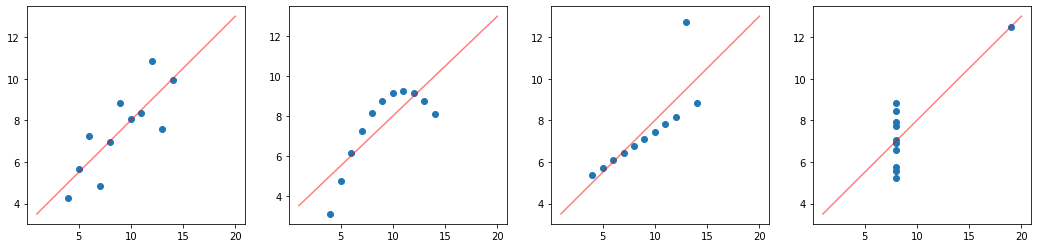

In [52]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
fig.set_size_inches(18, 4)

x = np.linspace(1, 20, 20)

ax1.scatter(df['x1'], df['y1'])
ax1.plot(x, b0 + b1 * x, color='red', alpha=0.5)

ax2.scatter(df['x2'], df['y2'])
ax2.plot(x, b0 + b1 * x, color='red', alpha=0.5)

ax3.scatter(df['x3'], df['y3'])
ax3.plot(x, b0 + b1 * x, color='red', alpha=0.5)

ax4.scatter(df['x4'], df['y4'])
ax4.plot(x, b0 + b1 * x, color='red', alpha=0.5)

plt.show()